In [111]:
import numpy as np
import pandas as pd
import scanpy as sc
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.4 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.2 pynndescent==0.5.8


In [112]:
results_file = '../results/SC-HCC-P2-Tumer.h5ad'  # the file that will store the analysis results

In [113]:
adata = sc.read_10x_mtx(
    '../data/SC-HCC-P2-Tumor/20180416-HCC-P2-Tumor/filtered_gene_bc_matrices/hg19',
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)

... reading from cache file cache/..-data-SC-HCC-P2-Tumor-20180416-HCC-P2-Tumor-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [114]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [115]:
adata

AnnData object with n_obs × n_vars = 6881 × 32738
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


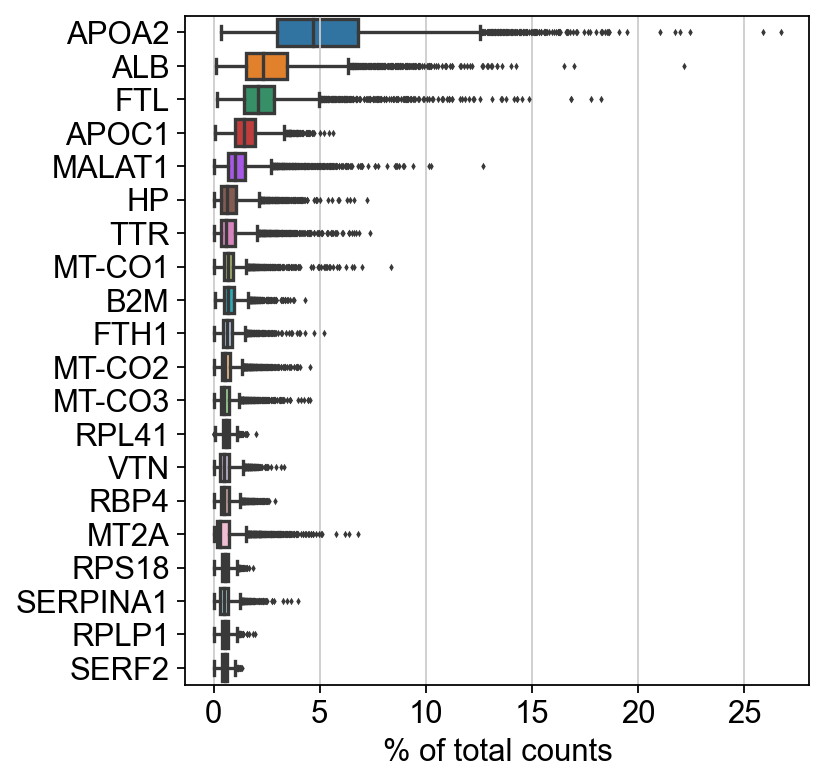

In [116]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [117]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 14485 genes that are detected in less than 3 cells


Assemble some information about mitochondrial genes, which are important for quality control.

In [118]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

AnnData object with n_obs × n_vars = 4719 × 1297
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

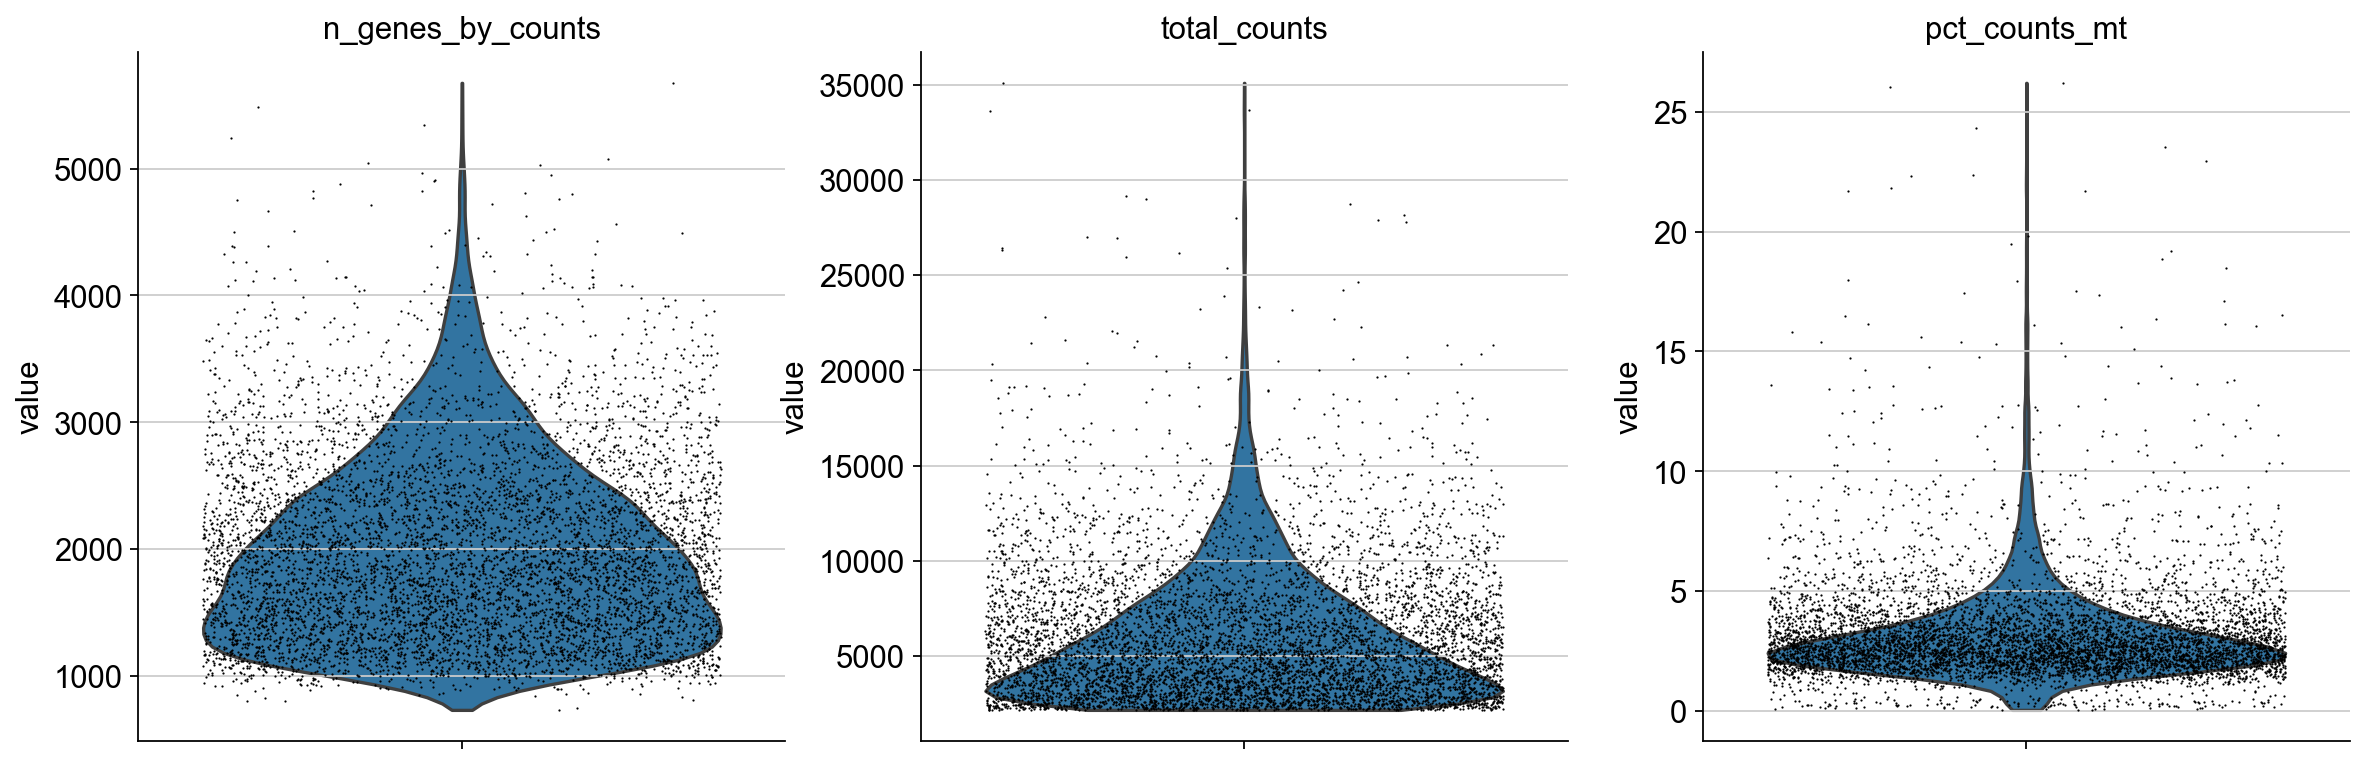

In [119]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

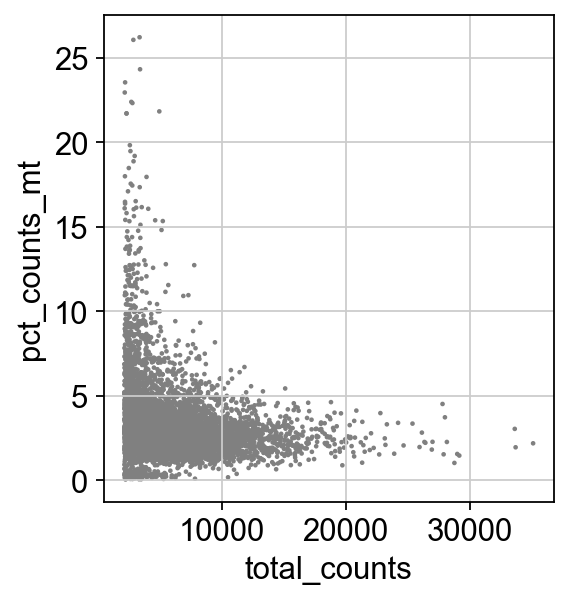

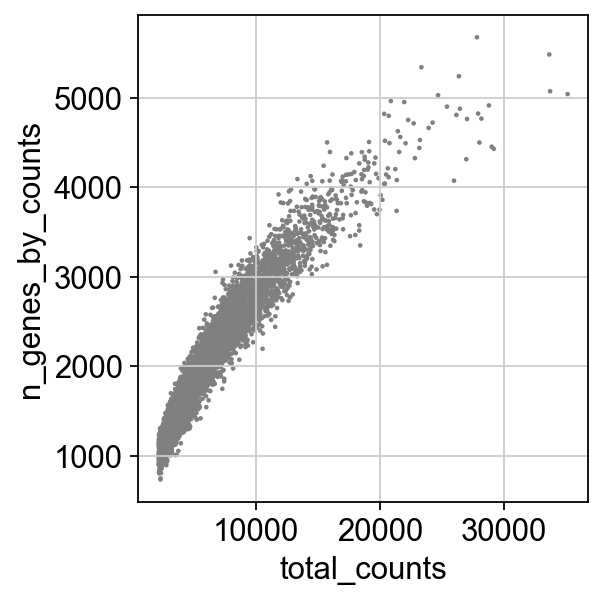

In [120]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [121]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [122]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/home/yuxin/.conda/envs/scanpy/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [123]:
sc.pp.log1p(adata)

In [124]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


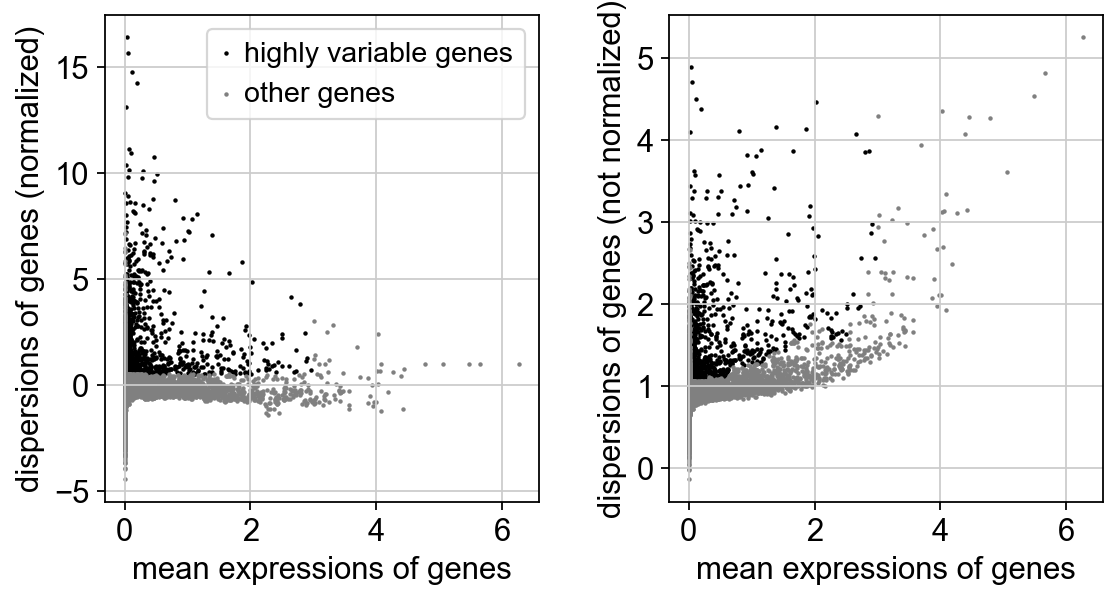

In [125]:
sc.pl.highly_variable_genes(adata)

In [126]:
adata.raw = adata

In [127]:
adata = adata[:, adata.var.highly_variable]

In [128]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:07)


In [129]:
sc.pp.scale(adata, max_value=10)

In [130]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


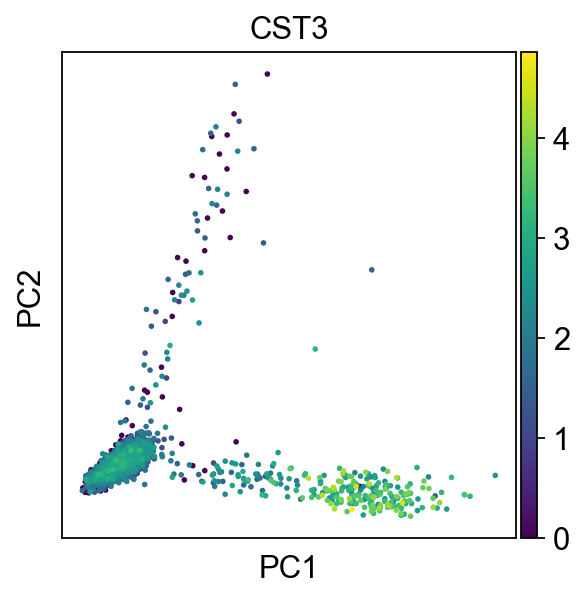

In [131]:
sc.pl.pca(adata, color='CST3')

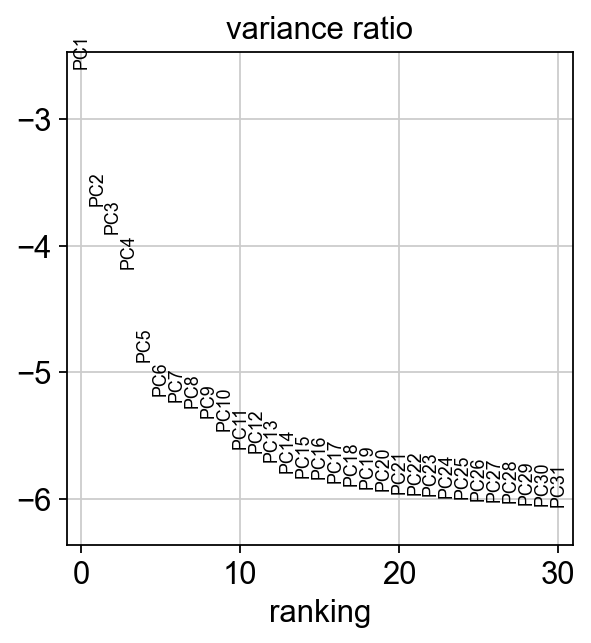

In [132]:
sc.pl.pca_variance_ratio(adata, log=True)

In [133]:
adata.write(results_file)

In [134]:
adata

AnnData object with n_obs × n_vars = 4719 × 1297
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [135]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


## UMAP Visualization

/home/yuxin/.conda/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


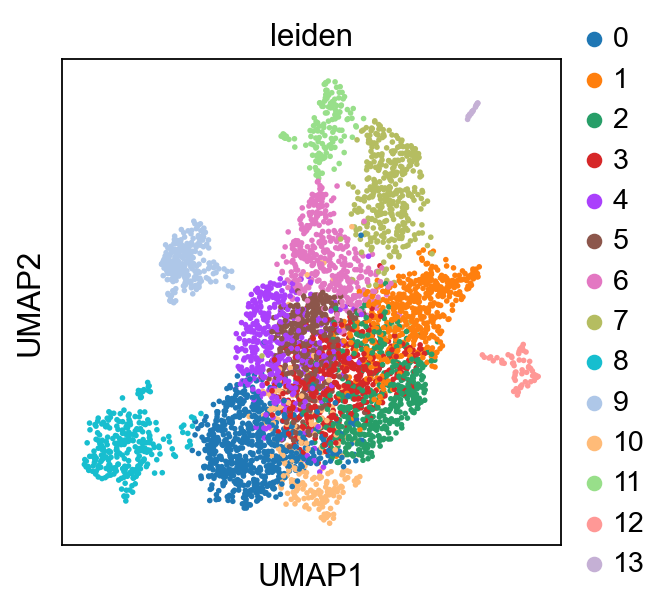

In [146]:
sc.pl.umap(adata, color=['leiden'])

In [139]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

ValueError: You need to run `tl.leiden` or `tl.louvain` to compute community labels, or specify `groups='an_existing_key'`

In [140]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


In [141]:
adata.var_names

Index(['ISG15', 'TNFRSF4', 'MMP23B', 'GABRD', 'RBP7', 'MASP2', 'TNFRSF1B',
       'TMEM51', 'SPATA21', 'PLA2G2A',
       ...
       'TFF3', 'CRYAA', 'AP001055.6', 'ICOSLG', 'ITGB2', 'COL6A1', 'COL6A2',
       'S100B', 'MT-ND2', 'MT-ATP6'],
      dtype='object', length=1297)

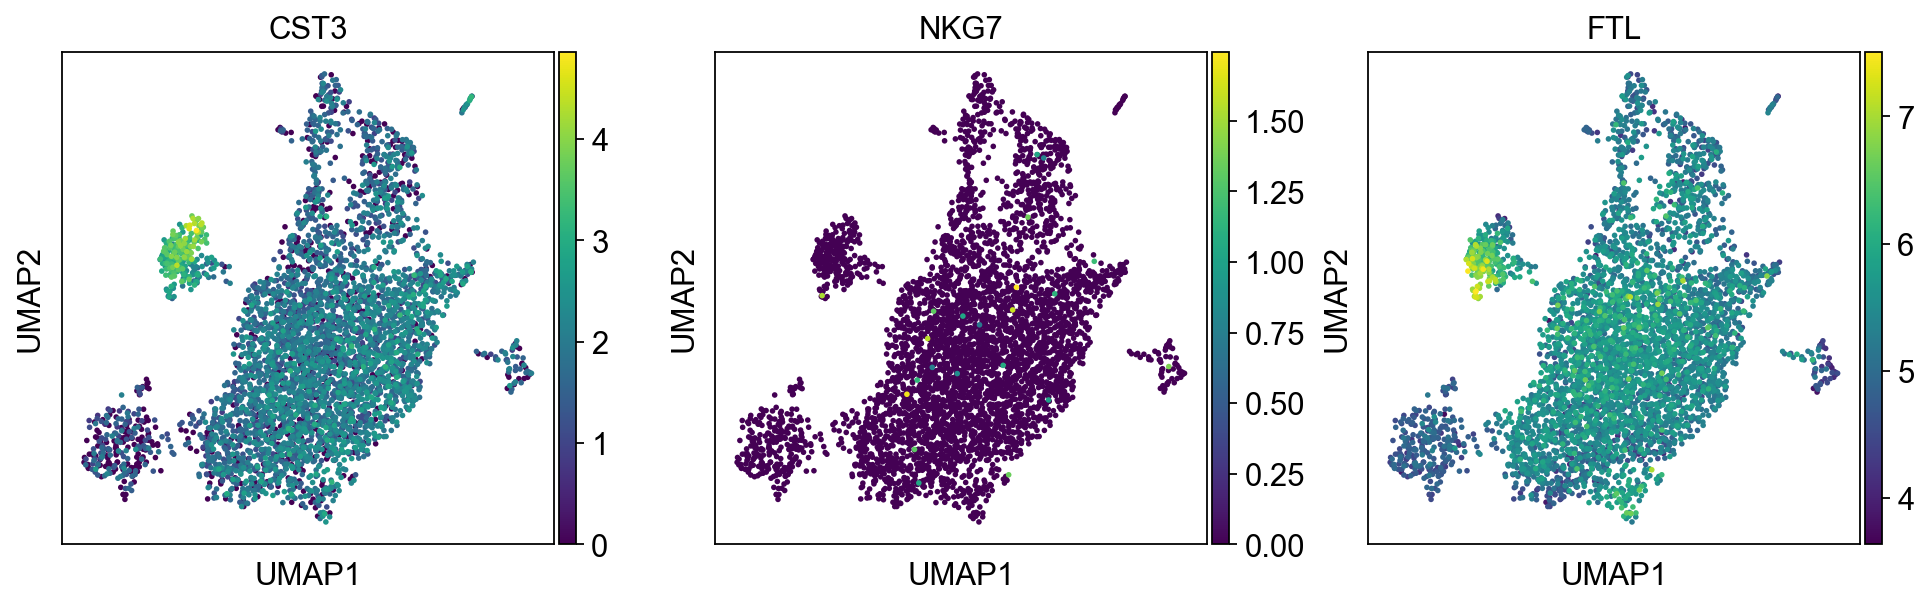

In [142]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'FTL'])

In [143]:
adata.var_names

Index(['ISG15', 'TNFRSF4', 'MMP23B', 'GABRD', 'RBP7', 'MASP2', 'TNFRSF1B',
       'TMEM51', 'SPATA21', 'PLA2G2A',
       ...
       'TFF3', 'CRYAA', 'AP001055.6', 'ICOSLG', 'ITGB2', 'COL6A1', 'COL6A2',
       'S100B', 'MT-ND2', 'MT-ATP6'],
      dtype='object', length=1297)

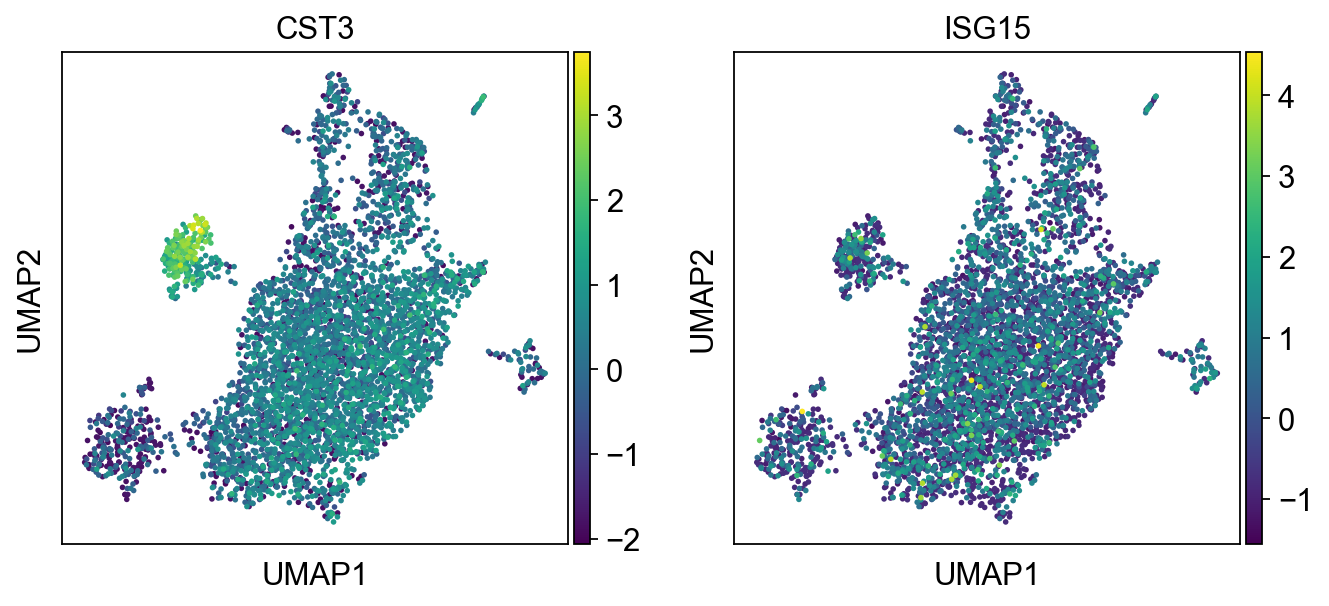

In [144]:
sc.pl.umap(adata, color=['CST3', 'ISG15'], use_raw=False)

In [145]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [138]:
adata.write(results_file)

## Finding Marker Genes
Used t-test to rank expression level.

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
adata.write(results_file)

In [ ]:
# marker_genes = ['IL7R', 'CD79A', 'CD8A', 'CD8B', 'LYZ', 'CD14',
#                 'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
#                 'FCGR3A', 'MS4A7', 'FCER1A', 'CST3']
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')

In [ ]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=10)

| group |        marker cell |         cell type          |
|:------|-------------------:|:--------------------------:|
| 0     |     SERPINC1, A1BG |        Hepatocytes         |
| 1     |          SOD2, UBD |        Macrophages         |
| 2     |      TSPAN8, DEFB1 |        Enterocytes         |
| 3     | EGR1, FOSB, HSPA1A |        Fibroblasts         |
| 4     |               MT1G |   Proximal tubular cells   |
| 5     |               CPS1 |        Hepatocytes         |
| 6     |      TROAP, AKR1C3 |      Pancreatic cells      |
| 7     |           DEK, TK1 |     Non-specific           |
| 8     |        APOC3, A1BG |        Hepatocytes         |
| 9     |          HLA-DPB1  |        Macrophages         |
| 10    |              APOA2 |        Hepatocytes         |
| 11    |         TOP2A, TK1 |        Non-specific        |
| 12    |       IFI27, GNG11 | Pancreatic endocrine cells |
| 13    |     MYL9, NDUFA4L2 |    Smooth muscle cells     |


In [ ]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=10, values_to_plot='logfoldchanges', min_logfoldchange=3, vmax=7, vmin=-7, cmap='bwr')

In [147]:
new_cluster_names = [
    'Hepatocytes(1)', 'Macrophages(1)',
    'Enterocytes', 'Fibroblasts',
    'Proximal tubular cells', 'Hepatocytes(2)',
    'Pancreatic cells', 'NA(1)',
    'Hepatocytes(3)', 'Macrophages(2)',
    'Hepatocytes(4)', 'NA(2)',
    'Pancreatic endocrine cells', 'Smooth muscle cells'
    ]
adata.rename_categories('leiden', new_cluster_names)

/home/yuxin/.conda/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1160: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


/home/yuxin/.conda/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


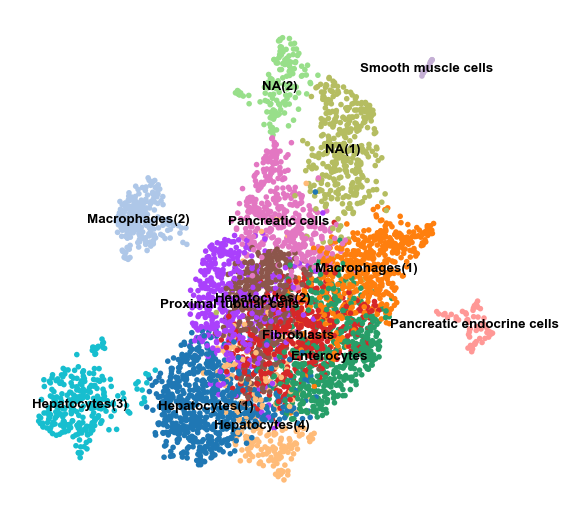

In [148]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', legend_fontsize=6, title='', frameon=False, save='.pdf')